In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)

In [26]:
results=p.map(ff, range(1,40),chunksize=1)

5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 14.804288


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)


(9119, 242) (9119,) (9119,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36711	valid-rmse:2.40007


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 15.133374


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)


(9948, 242) (9948,) (9948,)


[50]	train-rmse:0.716156	valid-rmse:0.73739


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36089	valid-rmse:2.39276


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


7


(1, 829, 517) (60, 829, 517)


8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 16.310143


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 17.574337


(829, 517, 18)


(829, 517, 32)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (311610, 2) (78020, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1576


0


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)


(10777, 242) (10777,) (10777,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)


(11606, 242) (11606,) (11606,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37763	valid-rmse:2.4059


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.39033	valid-rmse:2.41772


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.501486	valid-rmse:0.532599


[50]	train-rmse:0.7166	valid-rmse:0.736825


[150]	train-rmse:0.477107	valid-rmse:0.516762


[100]	train-rmse:0.503317	valid-rmse:0.533371


[50]	train-rmse:0.716782	valid-rmse:0.735036


[50]	train-rmse:0.719241	valid-rmse:0.737597


[200]	train-rmse:0.467235	valid-rmse:0.513769


[150]	train-rmse:0.478883	valid-rmse:0.517511


[250]	train-rmse:0.459611	valid-rmse:0.512612


[100]	train-rmse:0.500227	valid-rmse:0.529152


[100]	train-rmse:0.500488	valid-rmse:0.528598


[200]	train-rmse:0.468229	valid-rmse:0.514377


[300]	train-rmse:0.452162	valid-rmse:0.511803


[250]	train-rmse:0.460148	valid-rmse:0.513319


[150]	train-rmse:0.47545	valid-rmse:0.513322


[350]	train-rmse:0.445528	valid-rmse:0.511283


[150]	train-rmse:0.475027	valid-rmse:0.511542


[300]	train-rmse:0.453115	valid-rmse:0.512602


[400]	train-rmse:0.439876	valid-rmse:0.51106


[200]	train-rmse:0.465309	valid-rmse:0.510351


[350]	train-rmse:0.446433	valid-rmse:0.512221


[200]	train-rmse:0.464787	valid-rmse:0.508319


[450]	train-rmse:0.434175	valid-rmse:0.510885


[250]	train-rmse:0.457531	valid-rmse:0.509036


[400]	train-rmse:0.441276	valid-rmse:0.512


[500]	train-rmse:0.428718	valid-rmse:0.51062


[250]	train-rmse:0.457312	valid-rmse:0.507252


[300]	train-rmse:0.451083	valid-rmse:0.508288


[450]	train-rmse:0.43566	valid-rmse:0.51164


[550]	train-rmse:0.423874	valid-rmse:0.510441


[300]	train-rmse:0.450297	valid-rmse:0.506631


[350]	train-rmse:0.445228	valid-rmse:0.508007


[500]	train-rmse:0.430605	valid-rmse:0.511481


[600]	train-rmse:0.419029	valid-rmse:0.510271


[550]	train-rmse:0.426095	valid-rmse:0.51141


[650]	train-rmse:0.414306	valid-rmse:0.510322


[400]	train-rmse:0.439882	valid-rmse:0.507801


Stopping. Best iteration:
[612]	train-rmse:0.418081	valid-rmse:0.510243



[350]	train-rmse:0.444728	valid-rmse:0.506302


0.17479162 0.26034752


[0.26034752]


-1 mean score 0.26034752


0.174555271864


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905646  0.023464  0.185021    7  2017-04-16
472     2.507290  2.519464 -0.012174  0.179202    1  2017-04-17
473     2.661330  2.657362  0.003968  0.204915    2  2017-04-18
474     2.754815  2.741464  0.013350  0.162358    3  2017-04-19
475     2.713762  2.722720 -0.008958  0.206893    4  2017-04-20
476     2.999000  2.993460  0.005539  0.134421    5  2017-04-21
477     3.075529  3.077333 -0.001804  0.149077    6  2017-04-22

0.174555271864


pred         y     error    error2  day        date
dayidx                                                         
471     2.905646  2.929110  0.023464  0.185021    7  2017-04-16
472     2.519464  2.507290 -0.012174  0.179202    1  2017-04-17
473     2.657362  2.661330  0.003968  0.204915    2  2017-04-18
474     2.741464  2.754815  0.013350  0.162358    3  2017-04-19
475     2.722720  2.713762 -0.008958  0.206893    4  2017-04-20
476     2.993460  2.999000  0.005539  0.134421    5  2017-04-21
477     3.077333  3.075529 -0.001804  0.149077    6  2017-04-22

(829, 242)


9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 18.806503


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1576


0


[600]	train-rmse:0.420949	valid-rmse:0.511311


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)


(12435, 242) (12435,) (12435,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[450]	train-rmse:0.43431	valid-rmse:0.507612


[0]	train-rmse:2.38917	valid-rmse:2.41893


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.439134	valid-rmse:0.506051


[650]	train-rmse:0.416445	valid-rmse:0.511255


[500]	train-rmse:0.429509	valid-rmse:0.507476


[700]	train-rmse:0.411873	valid-rmse:0.511114


[50]	train-rmse:0.723204	valid-rmse:0.74419


[450]	train-rmse:0.434747	valid-rmse:0.505939


[550]	train-rmse:0.424607	valid-rmse:0.507345


[750]	train-rmse:0.407479	valid-rmse:0.511055


[500]	train-rmse:0.430398	valid-rmse:0.505813


[100]	train-rmse:0.505405	valid-rmse:0.537041


[800]	train-rmse:0.403224	valid-rmse:0.511048


[600]	train-rmse:0.419961	valid-rmse:0.507379


Stopping. Best iteration:
[775]	train-rmse:0.405362	valid-rmse:0.511009



Stopping. Best iteration:
[574]	train-rmse:0.422398	valid-rmse:0.507293



0.1643185 0.26113066


[0.26113066]


-1 mean score 0.26113066


0.167713403702


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916897  0.012213  0.180111    7  2017-04-16
472     2.507290  2.519652 -0.012362  0.172328    1  2017-04-17
473     2.661330  2.650543  0.010787  0.200281    2  2017-04-18
474     2.754815  2.731516  0.023299  0.165388    3  2017-04-19
475     2.713762  2.718853 -0.005092  0.182454    4  2017-04-20
476     2.999000  2.979217  0.019783  0.127784    5  2017-04-21
477     3.075529  3.092817 -0.017287  0.145648    6  2017-04-22

0.167713403702


pred         y     error    error2  day        date
dayidx                                                         
471     2.916897  2.929110  0.012213  0.180111    7  2017-04-16
472     2.519652  2.507290 -0.012362  0.172328    1  2017-04-17
473     2.650543  2.661330  0.010787  0.200281    2  2017-04-18
474     2.731516  2.754815  0.023299  0.165388    3  2017-04-19
475     2.718853  2.713762 -0.005092  0.182454    4  2017-04-20
476     2.979217  2.999000  0.019783  0.127784    5  2017-04-21
477     3.092817  3.075529 -0.017287  0.145648    6  2017-04-22

(829, 242)


10


(1, 829, 517) (60, 829, 517)


0.1784203 0.25734603


[0.25734603]


-1 mean score 0.25734603


0.186974182725


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915475  0.013635  0.207338    7  2017-04-16
472     2.507290  2.550650 -0.043359  0.197023    1  2017-04-17
473     2.661330  2.656037  0.005292  0.225463    2  2017-04-18
474     2.754815  2.732090  0.022724  0.180511    3  2017-04-19
475     2.713762  2.707430  0.006331  0.195410    4  2017-04-20
476     2.999000  2.991513  0.007486  0.130633    5  2017-04-21
477     3.075529  3.118570 -0.043041  0.172440    6  2017-04-22

0.186974182725


pred         y     error    error2  day        date
dayidx                                                         
471     2.915475  2.929110  0.013635  0.207338    7  2017-04-16
472     2.550650  2.507290 -0.043359  0.197023    1  2017-04-17
473     2.656037  2.661330  0.005292  0.225463    2  2017-04-18
474     2.732090  2.754815  0.022724  0.180511    3  2017-04-19
475     2.707430  2.713762  0.006331  0.195410    4  2017-04-20
476     2.991513  2.999000  0.007486  0.130633    5  2017-04-21
477     3.118570  3.075529 -0.043041  0.172440    6  2017-04-22

(829, 242)


11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 19.926521


(829, 517, 18)


(829, 517, 32)


[550]	train-rmse:0.425579	valid-rmse:0.505594


train/valid # (311610, 2) (78020, 2)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 21.05768


(829, 517, 18)


(829, 517, 32)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (311610, 2) (78020, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1576


0


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


[150]	train-rmse:0.479258	valid-rmse:0.51995


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)


(13264, 242) (13264,) (13264,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)


(14093, 242) (14093,) (14093,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38067	valid-rmse:2.41132


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.37264	valid-rmse:2.4041


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.421412	valid-rmse:0.505508


[200]	train-rmse:0.468363	valid-rmse:0.516535


[650]	train-rmse:0.416865	valid-rmse:0.505483


[50]	train-rmse:0.723112	valid-rmse:0.743861


[50]	train-rmse:0.723704	valid-rmse:0.745136


[250]	train-rmse:0.459326	valid-rmse:0.515339


Stopping. Best iteration:
[649]	train-rmse:0.416984	valid-rmse:0.505482



0.1738754 0.25551257


[0.25551257]


-1 mean score 0.25551257


0.185614898801


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936376 -0.007266  0.209724    7  2017-04-16
472     2.507290  2.551499 -0.044209  0.197954    1  2017-04-17
473     2.661330  2.654629  0.006701  0.221431    2  2017-04-18
474     2.754815  2.741601  0.013214  0.182904    3  2017-04-19
475     2.713762  2.716212 -0.002450  0.199281    4  2017-04-20
476     2.999000  2.969676  0.029323  0.132685    5  2017-04-21
477     3.075529  3.095097 -0.019568  0.155324    6  2017-04-22

0.185614898801


pred         y     error    error2  day        date
dayidx                                                         
471     2.936376  2.929110 -0.007266  0.209724    7  2017-04-16
472     2.551499  2.507290 -0.044209  0.197954    1  2017-04-17
473     2.654629  2.661330  0.006701  0.221431    2  2017-04-18
474     2.741601  2.754815  0.013214  0.182904    3  2017-04-19
475     2.716212  2.713762 -0.002450  0.199281    4  2017-04-20
476     2.969676  2.999000  0.029323  0.132685    5  2017-04-21
477     3.095097  3.075529 -0.019568  0.155324    6  2017-04-22

(829, 242)


12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 22.115147


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)


(14922, 242) (14922,) (14922,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[300]	train-rmse:0.452455	valid-rmse:0.514695


[0]	train-rmse:2.36805	valid-rmse:2.39891


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.508112	valid-rmse:0.539959


[100]	train-rmse:0.50914	valid-rmse:0.540604


[350]	train-rmse:0.446401	valid-rmse:0.514352


[150]	train-rmse:0.482131	valid-rmse:0.523231


[50]	train-rmse:0.722374	valid-rmse:0.743437


[400]	train-rmse:0.440905	valid-rmse:0.514107


[150]	train-rmse:0.483149	valid-rmse:0.524151


[450]	train-rmse:0.435752	valid-rmse:0.513965


[200]	train-rmse:0.471499	valid-rmse:0.519951


[100]	train-rmse:0.509171	valid-rmse:0.541901


[500]	train-rmse:0.430736	valid-rmse:0.513787


[200]	train-rmse:0.472091	valid-rmse:0.520544


[250]	train-rmse:0.462606	valid-rmse:0.518683


[550]	train-rmse:0.426047	valid-rmse:0.513662


[150]	train-rmse:0.483231	valid-rmse:0.525564


[300]	train-rmse:0.455201	valid-rmse:0.518193


[250]	train-rmse:0.463895	valid-rmse:0.519373


[600]	train-rmse:0.421797	valid-rmse:0.513527


[350]	train-rmse:0.449181	valid-rmse:0.517841


[200]	train-rmse:0.472209	valid-rmse:0.522474


[300]	train-rmse:0.456076	valid-rmse:0.518781


[650]	train-rmse:0.417255	valid-rmse:0.513517


Stopping. Best iteration:
[618]	train-rmse:0.420086	valid-rmse:0.513516



[400]	train-rmse:0.443355	valid-rmse:0.517589


0.17647257 0.26369864


[0.26369864]


-1 mean score 0.26369864


0.186165839434


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933172 -0.004062  0.195928    7  2017-04-16
472     2.507290  2.548052 -0.040761  0.208282    1  2017-04-17
473     2.661330  2.678318 -0.016988  0.226122    2  2017-04-18
474     2.754815  2.730181  0.024634  0.182939    3  2017-04-19
475     2.713762  2.712677  0.001084  0.200320    4  2017-04-20
476     2.999000  2.975464  0.023536  0.135486    5  2017-04-21
477     3.075529  3.089585 -0.014056  0.154085    6  2017-04-22

0.186165839434


pred         y     error    error2  day        date
dayidx                                                         
471     2.933172  2.929110 -0.004062  0.195928    7  2017-04-16
472     2.548052  2.507290 -0.040761  0.208282    1  2017-04-17
473     2.678318  2.661330 -0.016988  0.226122    2  2017-04-18
474     2.730181  2.754815  0.024634  0.182939    3  2017-04-19
475     2.712677  2.713762  0.001084  0.200320    4  2017-04-20
476     2.975464  2.999000  0.023536  0.135486    5  2017-04-21
477     3.089585  3.075529 -0.014056  0.154085    6  2017-04-22

(829, 242)


13


(1, 829, 517) (60, 829, 517)


[250]	train-rmse:0.462885	valid-rmse:0.521253


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 23.15517


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


[350]	train-rmse:0.449404	valid-rmse:0.518401


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)


(15751, 242) (15751,) (15751,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[450]	train-rmse:0.438109	valid-rmse:0.517431


[0]	train-rmse:2.3609	valid-rmse:2.3924


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.455063	valid-rmse:0.520452


[500]	train-rmse:0.433362	valid-rmse:0.51725


[400]	train-rmse:0.443505	valid-rmse:0.518168


[350]	train-rmse:0.448896	valid-rmse:0.520143


[550]	train-rmse:0.428995	valid-rmse:0.517201


[50]	train-rmse:0.722068	valid-rmse:0.742031


[450]	train-rmse:0.438094	valid-rmse:0.517896


[400]	train-rmse:0.443121	valid-rmse:0.519886


[600]	train-rmse:0.423524	valid-rmse:0.51723


Stopping. Best iteration:
[562]	train-rmse:0.427819	valid-rmse:0.517166



0.18302916 0.26746055


[0.26746055]


-1 mean score 0.26746055


0.18994872272


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929350 -0.000240  0.196267    7  2017-04-16
472     2.507290  2.547622 -0.040332  0.198723    1  2017-04-17
473     2.661330  2.657042  0.004288  0.235101    2  2017-04-18
474     2.754815  2.744174  0.010641  0.195243    3  2017-04-19
475     2.713762  2.723642 -0.009881  0.205322    4  2017-04-20
476     2.999000  2.985682  0.013318  0.142412    5  2017-04-21
477     3.075529  3.085922 -0.010393  0.156574    6  2017-04-22

0.18994872272


pred         y     error    error2  day        date
dayidx                                                         
471     2.929350  2.929110 -0.000240  0.196267    7  2017-04-16
472     2.547622  2.507290 -0.040332  0.198723    1  2017-04-17
473     2.657042  2.661330  0.004288  0.235101    2  2017-04-18
474     2.744174  2.754815  0.010641  0.195243    3  2017-04-19
475     2.723642  2.713762 -0.009881  0.205322    4  2017-04-20
476     2.985682  2.999000  0.013318  0.142412    5  2017-04-21
477     3.085922  3.075529 -0.010393  0.156574    6  2017-04-22

(829, 242)


14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 24.22639


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[500]	train-rmse:0.433076	valid-rmse:0.517767


[450]	train-rmse:0.438157	valid-rmse:0.519742


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


[100]	train-rmse:0.51019	valid-rmse:0.540843


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)


(16580, 242) (16580,) (16580,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37762	valid-rmse:2.40552


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.432984	valid-rmse:0.519623


[550]	train-rmse:0.427469	valid-rmse:0.517598


[150]	train-rmse:0.484403	valid-rmse:0.52442


[550]	train-rmse:0.427747	valid-rmse:0.519518


[600]	train-rmse:0.422592	valid-rmse:0.51745


[50]	train-rmse:0.722135	valid-rmse:0.739116


[600]	train-rmse:0.423302	valid-rmse:0.519505


[650]	train-rmse:0.417838	valid-rmse:0.517335


[200]	train-rmse:0.473515	valid-rmse:0.521187


[650]	train-rmse:0.418524	valid-rmse:0.519514


[100]	train-rmse:0.506937	valid-rmse:0.534677


[700]	train-rmse:0.413093	valid-rmse:0.517296


Stopping. Best iteration:
[617]	train-rmse:0.421714	valid-rmse:0.519468



0.17784275 0.26984742


[0.26984742]


-1 mean score 0.26984742


0.186376720667


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901106  0.028004  0.193057    7  2017-04-16
472     2.507290  2.537944 -0.030653  0.189967    1  2017-04-17
473     2.661330  2.664422 -0.003093  0.224726    2  2017-04-18
474     2.754815  2.738819  0.015996  0.190838    3  2017-04-19
475     2.713762  2.738017 -0.024256  0.206398    4  2017-04-20
476     2.999000  2.975672  0.023328  0.148189    5  2017-04-21
477     3.075529  3.079663 -0.004134  0.151462    6  2017-04-22

0.186376720667


pred         y     error    error2  day        date
dayidx                                                         
471     2.901106  2.929110  0.028004  0.193057    7  2017-04-16
472     2.537944  2.507290 -0.030653  0.189967    1  2017-04-17
473     2.664422  2.661330 -0.003093  0.224726    2  2017-04-18
474     2.738819  2.754815  0.015996  0.190838    3  2017-04-19
475     2.738017  2.713762 -0.024256  0.206398    4  2017-04-20
476     2.975672  2.999000  0.023328  0.148189    5  2017-04-21
477     3.079663  3.075529 -0.004134  0.151462    6  2017-04-22

(829, 242)


15


(1, 829, 517) (60, 829, 517)


[250]	train-rmse:0.464701	valid-rmse:0.520237


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 25.357664


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)


(17409, 242) (17409,) (17409,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[750]	train-rmse:0.408425	valid-rmse:0.517192


[0]	train-rmse:2.39055	valid-rmse:2.41552


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.481034	valid-rmse:0.518465


[300]	train-rmse:0.457334	valid-rmse:0.519623


[800]	train-rmse:0.404449	valid-rmse:0.517097


[200]	train-rmse:0.469533	valid-rmse:0.515111


Stopping. Best iteration:
[794]	train-rmse:0.404819	valid-rmse:0.51708



[50]	train-rmse:0.723278	valid-rmse:0.741628


[350]	train-rmse:0.451064	valid-rmse:0.519209


0.16387834 0.2673722


[0.2673722]


-1 mean score 0.2673722


0.17967812717


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910133  0.018977  0.188368    7  2017-04-16
472     2.507290  2.535505 -0.028215  0.177566    1  2017-04-17
473     2.661330  2.662183 -0.000853  0.221100    2  2017-04-18
474     2.754815  2.726632  0.028182  0.188645    3  2017-04-19
475     2.713762  2.748480 -0.034719  0.201773    4  2017-04-20
476     2.999000  2.985277  0.013722  0.133589    5  2017-04-21
477     3.075529  3.070876  0.004653  0.146706    6  2017-04-22

0.17967812717


pred         y     error    error2  day        date
dayidx                                                         
471     2.910133  2.929110  0.018977  0.188368    7  2017-04-16
472     2.535505  2.507290 -0.028215  0.177566    1  2017-04-17
473     2.662183  2.661330 -0.000853  0.221100    2  2017-04-18
474     2.726632  2.754815  0.028182  0.188645    3  2017-04-19
475     2.748480  2.713762 -0.034719  0.201773    4  2017-04-20
476     2.985277  2.999000  0.013722  0.133589    5  2017-04-21
477     3.070876  3.075529  0.004653  0.146706    6  2017-04-22

(829, 242)


16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 26.465925


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)


(18238, 242) (18238,) (18238,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.460389	valid-rmse:0.513906


[0]	train-rmse:2.38918	valid-rmse:2.41802


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.445104	valid-rmse:0.518893


[100]	train-rmse:0.505867	valid-rmse:0.536247


[450]	train-rmse:0.439809	valid-rmse:0.518709


[300]	train-rmse:0.453271	valid-rmse:0.513221


[50]	train-rmse:0.727395	valid-rmse:0.747828


[150]	train-rmse:0.47938	valid-rmse:0.519146


[500]	train-rmse:0.434564	valid-rmse:0.518574


[350]	train-rmse:0.447613	valid-rmse:0.512929


[100]	train-rmse:0.510961	valid-rmse:0.543029


[550]	train-rmse:0.429786	valid-rmse:0.518533


[200]	train-rmse:0.468151	valid-rmse:0.515944


[400]	train-rmse:0.44195	valid-rmse:0.512754


[600]	train-rmse:0.42485	valid-rmse:0.518459


[150]	train-rmse:0.484865	valid-rmse:0.526188


[250]	train-rmse:0.459365	valid-rmse:0.514696


[450]	train-rmse:0.436359	valid-rmse:0.512605


[650]	train-rmse:0.420115	valid-rmse:0.518499


Stopping. Best iteration:
[613]	train-rmse:0.423674	valid-rmse:0.518426



[200]	train-rmse:0.473893	valid-rmse:0.523187


[500]	train-rmse:0.431592	valid-rmse:0.512474


[300]	train-rmse:0.452008	valid-rmse:0.514003


0.17949937 0.26876512


[0.26876512]


-1 mean score 0.26876512


0.188896819949


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901996  0.027114  0.196710    7  2017-04-16
472     2.507290  2.528624 -0.021333  0.193442    1  2017-04-17
473     2.661330  2.660394  0.000936  0.235619    2  2017-04-18
474     2.754815  2.742926  0.011889  0.188781    3  2017-04-19
475     2.713762  2.748572 -0.034810  0.203953    4  2017-04-20
476     2.999000  2.983809  0.015190  0.146508    5  2017-04-21
477     3.075529  3.080448 -0.004919  0.157265    6  2017-04-22

0.188896819949


pred         y     error    error2  day        date
dayidx                                                         
471     2.901996  2.929110  0.027114  0.196710    7  2017-04-16
472     2.528624  2.507290 -0.021333  0.193442    1  2017-04-17
473     2.660394  2.661330  0.000936  0.235619    2  2017-04-18
474     2.742926  2.754815  0.011889  0.188781    3  2017-04-19
475     2.748572  2.713762 -0.034810  0.203953    4  2017-04-20
476     2.983809  2.999000  0.015190  0.146508    5  2017-04-21
477     3.080448  3.075529 -0.004919  0.157265    6  2017-04-22

(829, 242)


17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 27.605818


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)


(19067, 242) (19067,) (19067,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[550]	train-rmse:0.426885	valid-rmse:0.512463


[0]	train-rmse:2.3806	valid-rmse:2.41134


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


Stopping. Best iteration:
[505]	train-rmse:0.431215	valid-rmse:0.512449



[250]	train-rmse:0.4641	valid-rmse:0.521753


0.1859462 0.2626035


[0.2626035]


-1 mean score 0.2626035


0.197882726789


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888634  0.040476  0.224871    7  2017-04-16
472     2.507290  2.540204 -0.032913  0.204230    1  2017-04-17
473     2.661330  2.666220 -0.004890  0.242002    2  2017-04-18
474     2.754815  2.737877  0.016938  0.202503    3  2017-04-19
475     2.713762  2.747899 -0.034137  0.202805    4  2017-04-20
476     2.999000  2.989474  0.009525  0.140504    5  2017-04-21
477     3.075529  3.102393 -0.026863  0.168264    6  2017-04-22

0.197882726789


pred         y     error    error2  day        date
dayidx                                                         
471     2.888634  2.929110  0.040476  0.224871    7  2017-04-16
472     2.540204  2.507290 -0.032913  0.204230    1  2017-04-17
473     2.666220  2.661330 -0.004890  0.242002    2  2017-04-18
474     2.737877  2.754815  0.016938  0.202503    3  2017-04-19
475     2.747899  2.713762 -0.034137  0.202805    4  2017-04-20
476     2.989474  2.999000  0.009525  0.140504    5  2017-04-21
477     3.102393  3.075529 -0.026863  0.168264    6  2017-04-22

(829, 242)


[350]	train-rmse:0.446564	valid-rmse:0.513723


18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 28.75126


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)


(19896, 242) (19896,) (19896,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37157	valid-rmse:2.40338


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.456386	valid-rmse:0.521156


[50]	train-rmse:0.727741	valid-rmse:0.748666


[400]	train-rmse:0.441418	valid-rmse:0.513372


[350]	train-rmse:0.44975	valid-rmse:0.520678


[450]	train-rmse:0.436167	valid-rmse:0.5131


[50]	train-rmse:0.726631	valid-rmse:0.748025


[100]	train-rmse:0.51296	valid-rmse:0.54491


[400]	train-rmse:0.443456	valid-rmse:0.520358


[500]	train-rmse:0.431766	valid-rmse:0.512979


[450]	train-rmse:0.437889	valid-rmse:0.520188


[150]	train-rmse:0.486364	valid-rmse:0.527898


[100]	train-rmse:0.513317	valid-rmse:0.545244


[500]	train-rmse:0.43278	valid-rmse:0.520049


[550]	train-rmse:0.426405	valid-rmse:0.512836


[200]	train-rmse:0.474819	valid-rmse:0.52445


[150]	train-rmse:0.48669	valid-rmse:0.528167


[550]	train-rmse:0.428016	valid-rmse:0.519962


[600]	train-rmse:0.421849	valid-rmse:0.512748


[250]	train-rmse:0.465427	valid-rmse:0.5232


[600]	train-rmse:0.422886	valid-rmse:0.519929


[200]	train-rmse:0.474805	valid-rmse:0.524478


[650]	train-rmse:0.417272	valid-rmse:0.512636


[300]	train-rmse:0.457331	valid-rmse:0.522505


[650]	train-rmse:0.418169	valid-rmse:0.519836


[250]	train-rmse:0.465599	valid-rmse:0.523002


[700]	train-rmse:0.413045	valid-rmse:0.5125


[350]	train-rmse:0.451162	valid-rmse:0.522128


[700]	train-rmse:0.413327	valid-rmse:0.519725


[300]	train-rmse:0.458064	valid-rmse:0.522454


[400]	train-rmse:0.445142	valid-rmse:0.521904


[750]	train-rmse:0.408634	valid-rmse:0.512469


[750]	train-rmse:0.408438	valid-rmse:0.519698


[350]	train-rmse:0.451993	valid-rmse:0.522106


Stopping. Best iteration:
[736]	train-rmse:0.409815	valid-rmse:0.512455



[450]	train-rmse:0.438839	valid-rmse:0.521627


0.16794807 0.26260996


[0.26260996]


-1 mean score 0.26260996


[800]	train-rmse:0.40392	valid-rmse:0.519746


0.189945816994


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919615  0.009495  0.215610    7  2017-04-16
472     2.507290  2.535955 -0.028665  0.193269    1  2017-04-17
473     2.661330  2.665160 -0.003830  0.237676    2  2017-04-18
474     2.754815  2.741603  0.013211  0.183630    3  2017-04-19
475     2.713762  2.754287 -0.040525  0.201143    4  2017-04-20
476     2.999000  2.993228  0.005772  0.138062    5  2017-04-21
477     3.075529  3.094562 -0.019033  0.160231    6  2017-04-22

0.189945816994


pred         y     error    error2  day        date
dayidx                                                         
471     2.919615  2.929110  0.009495  0.215610    7  2017-04-16
472     2.535955  2.507290 -0.028665  0.193269    1  2017-04-17
473     2.665160  2.661330 -0.003830  0.237676    2  2017-04-18
474     2.741603  2.754815  0.013211  0.183630    3  2017-04-19
475     2.754287  2.713762 -0.040525  0.201143    4  2017-04-20
476     2.993228  2.999000  0.005772  0.138062    5  2017-04-21
477     3.094562  3.075529 -0.019033  0.160231    6  2017-04-22

(829, 242)


19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 29.798643


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


Stopping. Best iteration:
[763]	train-rmse:0.407208	valid-rmse:0.519641



train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1576


0


0.1658186 0.270027


[0.270027]


-1 mean score 0.270027


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


0.186218738556


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899433  0.029677  0.189100    7  2017-04-16
472     2.507290  2.534159 -0.026869  0.203910    1  2017-04-17
473     2.661330  2.654314  0.007016  0.233132    2  2017-04-18
474     2.754815  2.729939  0.024876  0.186751    3  2017-04-19
475     2.713762  2.749236 -0.035475  0.204553    4  2017-04-20
476     2.999000  3.003701 -0.004701  0.138783    5  2017-04-21
477     3.075529  3.086751 -0.011221  0.147303    6  2017-04-22

(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


0.186218738556


pred         y     error    error2  day        date
dayidx                                                         
471     2.899433  2.929110  0.029677  0.189100    7  2017-04-16
472     2.534159  2.507290 -0.026869  0.203910    1  2017-04-17
473     2.654314  2.661330  0.007016  0.233132    2  2017-04-18
474     2.729939  2.754815  0.024876  0.186751    3  2017-04-19
475     2.749236  2.713762 -0.035475  0.204553    4  2017-04-20
476     3.003701  2.999000 -0.004701  0.138783    5  2017-04-21
477     3.086751  3.075529 -0.011221  0.147303    6  2017-04-22

(829, 242)


20


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(1, 829, 517) (60, 829, 517)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)


(20725, 242) (20725,) (20725,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[500]	train-rmse:0.433839	valid-rmse:0.521526


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 30.796307


(829, 517, 18)


(829, 517, 32)


[400]	train-rmse:0.446217	valid-rmse:0.521716


train/valid # (311610, 2) (78020, 2)


[0]	train-rmse:2.36669	valid-rmse:2.39581


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)


(21554, 242) (21554,) (21554,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36005	valid-rmse:2.38899


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.428338	valid-rmse:0.521428


[450]	train-rmse:0.440958	valid-rmse:0.521575


[600]	train-rmse:0.423971	valid-rmse:0.521344


[50]	train-rmse:0.724796	valid-rmse:0.745934


[50]	train-rmse:0.725149	valid-rmse:0.744561


[500]	train-rmse:0.435795	valid-rmse:0.521444


[650]	train-rmse:0.419023	valid-rmse:0.521352


Stopping. Best iteration:
[617]	train-rmse:0.422132	valid-rmse:0.521286



0.17819549 0.27173933


[0.27173933]


-1 mean score 0.27173933


0.19271838665


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891311  0.037799  0.199185    7  2017-04-16
472     2.507290  2.519114 -0.011823  0.187865    1  2017-04-17
473     2.661330  2.653218  0.008112  0.242650    2  2017-04-18
474     2.754815  2.722833  0.031982  0.199884    3  2017-04-19
475     2.713762  2.744428 -0.030667  0.216206    4  2017-04-20
476     2.999000  3.005012 -0.006013  0.141336    5  2017-04-21
477     3.075529  3.082337 -0.006808  0.161902    6  2017-04-22

0.19271838665


pred         y     error    error2  day        date
dayidx                                                         
471     2.891311  2.929110  0.037799  0.199185    7  2017-04-16
472     2.519114  2.507290 -0.011823  0.187865    1  2017-04-17
473     2.653218  2.661330  0.008112  0.242650    2  2017-04-18
474     2.722833  2.754815  0.031982  0.199884    3  2017-04-19
475     2.744428  2.713762 -0.030667  0.216206    4  2017-04-20
476     3.005012  2.999000 -0.006013  0.141336    5  2017-04-21
477     3.082337  3.075529 -0.006808  0.161902    6  2017-04-22

(829, 242)


21


(1, 829, 517) (60, 829, 517)


[100]	train-rmse:0.512107	valid-rmse:0.545646


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 31.792852


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[550]	train-rmse:0.430137	valid-rmse:0.521375


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)


(22383, 242) (22383,) (22383,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37641	valid-rmse:2.4024


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.514061	valid-rmse:0.54608


[150]	train-rmse:0.485828	valid-rmse:0.529256


[600]	train-rmse:0.425204	valid-rmse:0.521286


[200]	train-rmse:0.474078	valid-rmse:0.52598


[650]	train-rmse:0.421049	valid-rmse:0.521267


[50]	train-rmse:0.724681	valid-rmse:0.744586


[150]	train-rmse:0.487844	valid-rmse:0.529748


[700]	train-rmse:0.416621	valid-rmse:0.521199


[250]	train-rmse:0.464343	valid-rmse:0.524826


[100]	train-rmse:0.510185	valid-rmse:0.542659


[200]	train-rmse:0.476394	valid-rmse:0.526875


[300]	train-rmse:0.456715	valid-rmse:0.524067


[750]	train-rmse:0.411814	valid-rmse:0.521243


Stopping. Best iteration:
[710]	train-rmse:0.415599	valid-rmse:0.521188



0.17272295 0.27163744


[0.27163744]


-1 mean score 0.27163744


0.191704273224


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896018  0.033092  0.201919    7  2017-04-16
472     2.507290  2.533321 -0.026030  0.186194    1  2017-04-17
473     2.661330  2.659453  0.001877  0.230436    2  2017-04-18
474     2.754815  2.720960  0.033855  0.204712    3  2017-04-19
475     2.713762  2.727673 -0.013911  0.213495    4  2017-04-20
476     2.999000  2.998627  0.000372  0.148009    5  2017-04-21
477     3.075529  3.070553  0.004976  0.157166    6  2017-04-22

0.191704273224


pred         y     error    error2  day        date
dayidx                                                         
471     2.896018  2.929110  0.033092  0.201919    7  2017-04-16
472     2.533321  2.507290 -0.026030  0.186194    1  2017-04-17
473     2.659453  2.661330  0.001877  0.230436    2  2017-04-18
474     2.720960  2.754815  0.033855  0.204712    3  2017-04-19
475     2.727673  2.713762 -0.013911  0.213495    4  2017-04-20
476     2.998627  2.999000  0.000372  0.148009    5  2017-04-21
477     3.070553  3.075529  0.004976  0.157166    6  2017-04-22

(829, 242)


22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 32.870983


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1576


0


[350]	train-rmse:0.449906	valid-rmse:0.5237


[250]	train-rmse:0.465946	valid-rmse:0.525633


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)


(23212, 242) (23212,) (23212,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[150]	train-rmse:0.484161	valid-rmse:0.526191


[0]	train-rmse:2.39061	valid-rmse:2.41406


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.44401	valid-rmse:0.523531


[300]	train-rmse:0.458245	valid-rmse:0.525144


[200]	train-rmse:0.472683	valid-rmse:0.522942


[450]	train-rmse:0.438648	valid-rmse:0.523404


[350]	train-rmse:0.451605	valid-rmse:0.524815


[50]	train-rmse:0.725769	valid-rmse:0.744681


[500]	train-rmse:0.433351	valid-rmse:0.523357


[250]	train-rmse:0.462818	valid-rmse:0.521652


[400]	train-rmse:0.445442	valid-rmse:0.524544


[550]	train-rmse:0.428669	valid-rmse:0.523263


[100]	train-rmse:0.508617	valid-rmse:0.541295


[300]	train-rmse:0.454966	valid-rmse:0.521058


Stopping. Best iteration:
[528]	train-rmse:0.430459	valid-rmse:0.52324



[450]	train-rmse:0.440303	valid-rmse:0.524383


0.18529525 0.27377993


[0.27377993]


-1 mean score 0.27377993


0.198167458177


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887998  0.041112  0.210296    7  2017-04-16
472     2.507290  2.533927 -0.026637  0.195154    1  2017-04-17
473     2.661330  2.649887  0.011443  0.239381    2  2017-04-18
474     2.754815  2.720046  0.034769  0.198238    3  2017-04-19
475     2.713762  2.728631 -0.014870  0.222981    4  2017-04-20
476     2.999000  2.977598  0.021402  0.154216    5  2017-04-21
477     3.075529  3.070407  0.005122  0.166904    6  2017-04-22

0.198167458177


pred         y     error    error2  day        date
dayidx                                                         
471     2.887998  2.929110  0.041112  0.210296    7  2017-04-16
472     2.533927  2.507290 -0.026637  0.195154    1  2017-04-17
473     2.649887  2.661330  0.011443  0.239381    2  2017-04-18
474     2.720046  2.754815  0.034769  0.198238    3  2017-04-19
475     2.728631  2.713762 -0.014870  0.222981    4  2017-04-20
476     2.977598  2.999000  0.021402  0.154216    5  2017-04-21
477     3.070407  3.075529  0.005122  0.166904    6  2017-04-22

(829, 242)


23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 33.974537


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)


(24041, 242) (24041,) (24041,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[350]	train-rmse:0.448487	valid-rmse:0.520748


[0]	train-rmse:2.3892	valid-rmse:2.41494


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.435007	valid-rmse:0.524329


[150]	train-rmse:0.482158	valid-rmse:0.52439


[400]	train-rmse:0.442852	valid-rmse:0.520463


[550]	train-rmse:0.42975	valid-rmse:0.524234


[200]	train-rmse:0.470499	valid-rmse:0.521132


[50]	train-rmse:0.729901	valid-rmse:0.748909


Stopping. Best iteration:
[536]	train-rmse:0.431264	valid-rmse:0.52422



[450]	train-rmse:0.437907	valid-rmse:0.520212


0.18598904 0.27480638


[0.27480638]


-1 mean score 0.27480638


0.196643561125


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920182  0.008928  0.212695    7  2017-04-16
472     2.507290  2.535162 -0.027871  0.196426    1  2017-04-17
473     2.661330  2.652117  0.009213  0.233762    2  2017-04-18
474     2.754815  2.722954  0.031861  0.199730    3  2017-04-19
475     2.713762  2.725381 -0.011619  0.210138    4  2017-04-20
476     2.999000  2.961221  0.037778  0.158291    5  2017-04-21
477     3.075529  3.061623  0.013906  0.165463    6  2017-04-22

0.196643561125


pred         y     error    error2  day        date
dayidx                                                         
471     2.920182  2.929110  0.008928  0.212695    7  2017-04-16
472     2.535162  2.507290 -0.027871  0.196426    1  2017-04-17
473     2.652117  2.661330  0.009213  0.233762    2  2017-04-18
474     2.722954  2.754815  0.031861  0.199730    3  2017-04-19
475     2.725381  2.713762 -0.011619  0.210138    4  2017-04-20
476     2.961221  2.999000  0.037778  0.158291    5  2017-04-21
477     3.061623  3.075529  0.013906  0.165463    6  2017-04-22

(829, 242)


24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 35.208443


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)


(24870, 242) (24870,) (24870,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.3801	valid-rmse:2.40629


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.461298	valid-rmse:0.520118


[500]	train-rmse:0.43255	valid-rmse:0.519963


[100]	train-rmse:0.514061	valid-rmse:0.545744


[300]	train-rmse:0.453363	valid-rmse:0.519444


[550]	train-rmse:0.42794	valid-rmse:0.519894


[150]	train-rmse:0.487164	valid-rmse:0.52896


[50]	train-rmse:0.729428	valid-rmse:0.749861


[350]	train-rmse:0.447123	valid-rmse:0.519188


[600]	train-rmse:0.422671	valid-rmse:0.519822


[200]	train-rmse:0.475213	valid-rmse:0.52556


[100]	train-rmse:0.515322	valid-rmse:0.549254


[400]	train-rmse:0.441559	valid-rmse:0.518904


[650]	train-rmse:0.418223	valid-rmse:0.519796


[250]	train-rmse:0.465861	valid-rmse:0.524493


[450]	train-rmse:0.436548	valid-rmse:0.518732


[700]	train-rmse:0.413254	valid-rmse:0.519753


[150]	train-rmse:0.488564	valid-rmse:0.532597


[300]	train-rmse:0.45828	valid-rmse:0.523802


[500]	train-rmse:0.431463	valid-rmse:0.518689


[750]	train-rmse:0.408989	valid-rmse:0.519784


Stopping. Best iteration:
[714]	train-rmse:0.411871	valid-rmse:0.519687



[200]	train-rmse:0.476629	valid-rmse:0.529648


[350]	train-rmse:0.451571	valid-rmse:0.523417


0.16963762 0.27007455


[0.27007455]


-1 mean score 0.27007455


0.186695501208


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901463  0.027647  0.200672    7  2017-04-16
472     2.507290  2.542285 -0.034995  0.188897    1  2017-04-17
473     2.661330  2.660822  0.000507  0.225877    2  2017-04-18
474     2.754815  2.733868  0.020947  0.188571    3  2017-04-19
475     2.713762  2.715309 -0.001547  0.198414    4  2017-04-20
476     2.999000  2.980793  0.018206  0.142324    5  2017-04-21
477     3.075529  3.086081 -0.010552  0.162114    6  2017-04-22

0.186695501208


pred         y     error    error2  day        date
dayidx                                                         
471     2.901463  2.929110  0.027647  0.200672    7  2017-04-16
472     2.542285  2.507290 -0.034995  0.188897    1  2017-04-17
473     2.660822  2.661330  0.000507  0.225877    2  2017-04-18
474     2.733868  2.754815  0.020947  0.188571    3  2017-04-19
475     2.715309  2.713762 -0.001547  0.198414    4  2017-04-20
476     2.980793  2.999000  0.018206  0.142324    5  2017-04-21
477     3.086081  3.075529 -0.010552  0.162114    6  2017-04-22

(829, 242)


25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 36.335064


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


[550]	train-rmse:0.426642	valid-rmse:0.518529


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)


(25699, 242) (25699,) (25699,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37151	valid-rmse:2.40037


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.445389	valid-rmse:0.523271


[250]	train-rmse:0.466539	valid-rmse:0.528166


[600]	train-rmse:0.421866	valid-rmse:0.518498


[450]	train-rmse:0.440141	valid-rmse:0.523091


[50]	train-rmse:0.728635	valid-rmse:0.750478


[650]	train-rmse:0.417925	valid-rmse:0.518441


[300]	train-rmse:0.457927	valid-rmse:0.527668


[500]	train-rmse:0.435179	valid-rmse:0.522939


[100]	train-rmse:0.515593	valid-rmse:0.550271


[700]	train-rmse:0.413344	valid-rmse:0.518332


[550]	train-rmse:0.429937	valid-rmse:0.522791


[350]	train-rmse:0.451015	valid-rmse:0.527223


[600]	train-rmse:0.424006	valid-rmse:0.52269


[150]	train-rmse:0.488832	valid-rmse:0.533724


[750]	train-rmse:0.408534	valid-rmse:0.518346


[400]	train-rmse:0.445109	valid-rmse:0.526975


Stopping. Best iteration:
[705]	train-rmse:0.41282	valid-rmse:0.518315



0.17042011 0.26865065


[0.26865065]


-1 mean score 0.26865065


0.184679731727


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917888  0.011222  0.205302    7  2017-04-16
472     2.507290  2.525118 -0.017827  0.181034    1  2017-04-17
473     2.661330  2.670157 -0.008827  0.215175    2  2017-04-18
474     2.754815  2.739737  0.015078  0.192417    3  2017-04-19
475     2.713762  2.728945 -0.015184  0.201306    4  2017-04-20
476     2.999000  2.978097  0.020903  0.140479    5  2017-04-21
477     3.075529  3.076440 -0.000911  0.157046    6  2017-04-22

0.184679731727


pred         y     error    error2  day        date
dayidx                                                         
471     2.917888  2.929110  0.011222  0.205302    7  2017-04-16
472     2.525118  2.507290 -0.017827  0.181034    1  2017-04-17
473     2.670157  2.661330 -0.008827  0.215175    2  2017-04-18
474     2.739737  2.754815  0.015078  0.192417    3  2017-04-19
475     2.728945  2.713762 -0.015184  0.201306    4  2017-04-20
476     2.978097  2.999000  0.020903  0.140479    5  2017-04-21
477     3.076440  3.075529 -0.000911  0.157046    6  2017-04-22

(829, 242)


26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 37.374123


(829, 517, 18)


(829, 517, 32)


[650]	train-rmse:0.418888	valid-rmse:0.522622


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1576


0


[450]	train-rmse:0.439587	valid-rmse:0.526752


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


[200]	train-rmse:0.477082	valid-rmse:0.530476


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)


(26528, 242) (26528,) (26528,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36591	valid-rmse:2.39374


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[700]	train-rmse:0.413499	valid-rmse:0.522652


[500]	train-rmse:0.433926	valid-rmse:0.526581


Stopping. Best iteration:
[672]	train-rmse:0.416354	valid-rmse:0.522551



[250]	train-rmse:0.46762	valid-rmse:0.529212


0.17335023 0.27305955


[0.27305955]


-1 mean score 0.27305955


0.185619592667


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909690  0.019420  0.183243    7  2017-04-16
472     2.507290  2.522454 -0.015164  0.200110    1  2017-04-17
473     2.661330  2.656393  0.004937  0.228010    2  2017-04-18
474     2.754815  2.738057  0.016758  0.185685    3  2017-04-19
475     2.713762  2.731285 -0.017523  0.204524    4  2017-04-20
476     2.999000  2.986224  0.012776  0.145191    5  2017-04-21
477     3.075529  3.071034  0.004495  0.152576    6  2017-04-22

0.185619592667


pred         y     error    error2  day        date
dayidx                                                         
471     2.909690  2.929110  0.019420  0.183243    7  2017-04-16
472     2.522454  2.507290 -0.015164  0.200110    1  2017-04-17
473     2.656393  2.661330  0.004937  0.228010    2  2017-04-18
474     2.738057  2.754815  0.016758  0.185685    3  2017-04-19
475     2.731285  2.713762 -0.017523  0.204524    4  2017-04-20
476     2.986224  2.999000  0.012776  0.145191    5  2017-04-21
477     3.071034  3.075529  0.004495  0.152576    6  2017-04-22

(829, 242)


27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 38.450596


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1576


0


[50]	train-rmse:0.727285	valid-rmse:0.748693


[550]	train-rmse:0.428117	valid-rmse:0.526467


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)


(27357, 242) (27357,) (27357,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[300]	train-rmse:0.459638	valid-rmse:0.528501


[0]	train-rmse:2.35983	valid-rmse:2.38677


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.423062	valid-rmse:0.526327


[350]	train-rmse:0.452604	valid-rmse:0.528122


[100]	train-rmse:0.515586	valid-rmse:0.55053


[50]	train-rmse:0.727091	valid-rmse:0.746735


[650]	train-rmse:0.41793	valid-rmse:0.526203


[400]	train-rmse:0.446316	valid-rmse:0.527902


[150]	train-rmse:0.489481	valid-rmse:0.534265


[700]	train-rmse:0.41283	valid-rmse:0.526145


[100]	train-rmse:0.516573	valid-rmse:0.549314


[450]	train-rmse:0.440496	valid-rmse:0.527815


[750]	train-rmse:0.408095	valid-rmse:0.526098


[200]	train-rmse:0.477826	valid-rmse:0.531265


[500]	train-rmse:0.435	valid-rmse:0.527735


[150]	train-rmse:0.490651	valid-rmse:0.533205


[800]	train-rmse:0.403539	valid-rmse:0.526048


[550]	train-rmse:0.429078	valid-rmse:0.527648


[250]	train-rmse:0.468455	valid-rmse:0.530202


[200]	train-rmse:0.479286	valid-rmse:0.530184


Stopping. Best iteration:
[538]	train-rmse:0.430631	valid-rmse:0.527623



[850]	train-rmse:0.399062	valid-rmse:0.526044


0.18544263 0.2783862


[0.2783862]


-1 mean score 0.2783862


0.193546876311


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911236  0.017874  0.202677    7  2017-04-16
472     2.507290  2.519586 -0.012295  0.191717    1  2017-04-17
473     2.661330  2.658275  0.003055  0.227553    2  2017-04-18
474     2.754815  2.727353  0.027462  0.200277    3  2017-04-19
475     2.713762  2.719751 -0.005989  0.213000    4  2017-04-20
476     2.999000  2.973892  0.025107  0.157652    5  2017-04-21
477     3.075529  3.067498  0.008031  0.161952    6  2017-04-22

0.193546876311


pred         y     error    error2  day        date
dayidx                                                         
471     2.911236  2.929110  0.017874  0.202677    7  2017-04-16
472     2.519586  2.507290 -0.012295  0.191717    1  2017-04-17
473     2.658275  2.661330  0.003055  0.227553    2  2017-04-18
474     2.727353  2.754815  0.027462  0.200277    3  2017-04-19
475     2.719751  2.713762 -0.005989  0.213000    4  2017-04-20
476     2.973892  2.999000  0.025107  0.157652    5  2017-04-21
477     3.067498  3.075529  0.008031  0.161952    6  2017-04-22

(829, 242)


28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 39.47981


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


Stopping. Best iteration:
[817]	train-rmse:0.402028	valid-rmse:0.526023



train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1576


0


[300]	train-rmse:0.460134	valid-rmse:0.529692


[250]	train-rmse:0.469936	valid-rmse:0.529049


0.16162673 0.2767001


[0.2767001]


-1 mean score 0.2767001


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


0.17746154964


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916138  0.012972  0.180906    7  2017-04-16
472     2.507290  2.506761  0.000529  0.169096    1  2017-04-17
473     2.661330  2.648368  0.012962  0.221364    2  2017-04-18
474     2.754815  2.744948  0.009867  0.182156    3  2017-04-19
475     2.713762  2.733835 -0.020074  0.199481    4  2017-04-20
476     2.999000  2.991570  0.007430  0.140641    5  2017-04-21
477     3.075529  3.065621  0.009908  0.148586    6  2017-04-22

0.17746154964


pred         y     error    error2  day        date
dayidx                                                         
471     2.916138  2.929110  0.012972  0.180906    7  2017-04-16
472     2.506761  2.507290  0.000529  0.169096    1  2017-04-17
473     2.648368  2.661330  0.012962  0.221364    2  2017-04-18
474     2.744948  2.754815  0.009867  0.182156    3  2017-04-19
475     2.733835  2.713762 -0.020074  0.199481    4  2017-04-20
476     2.991570  2.999000  0.007430  0.140641    5  2017-04-21
477     3.065621  3.075529  0.009908  0.148586    6  2017-04-22

(829, 242)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


29


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)


(1, 829, 517) (60, 829, 517)


(28186, 242) (28186,) (28186,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 40.793427


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[0]	train-rmse:2.37619	valid-rmse:2.40035


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)


(29015, 242) (29015,) (29015,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[350]	train-rmse:0.453666	valid-rmse:0.529305


[0]	train-rmse:2.3898	valid-rmse:2.41143


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.462095	valid-rmse:0.528448


[400]	train-rmse:0.447415	valid-rmse:0.529132


[50]	train-rmse:0.726893	valid-rmse:0.745995


[350]	train-rmse:0.455279	valid-rmse:0.528067


[450]	train-rmse:0.441635	valid-rmse:0.529089


[50]	train-rmse:0.727385	valid-rmse:0.746055


[100]	train-rmse:0.51279	valid-rmse:0.545448


[500]	train-rmse:0.436283	valid-rmse:0.528861


[400]	train-rmse:0.448688	valid-rmse:0.527866


[550]	train-rmse:0.431071	valid-rmse:0.528658


[150]	train-rmse:0.486565	valid-rmse:0.529166


[450]	train-rmse:0.442652	valid-rmse:0.527727


[100]	train-rmse:0.511162	valid-rmse:0.5444


[600]	train-rmse:0.425829	valid-rmse:0.528534


[500]	train-rmse:0.437185	valid-rmse:0.527719


Stopping. Best iteration:
[463]	train-rmse:0.440868	valid-rmse:0.527694



[200]	train-rmse:0.475182	valid-rmse:0.526045


0.19436441 0.27846044


[0.27846044]


-1 mean score 0.27846044


0.20225545764


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905861  0.023249  0.218716    7  2017-04-16
472     2.507290  2.532792 -0.025501  0.207657    1  2017-04-17
473     2.661330  2.661831 -0.000501  0.241006    2  2017-04-18
474     2.754815  2.735603  0.019211  0.202081    3  2017-04-19
475     2.713762  2.723589 -0.009828  0.218927    4  2017-04-20
476     2.999000  2.956605  0.042395  0.157236    5  2017-04-21
477     3.075529  3.085875 -0.010346  0.170166    6  2017-04-22

0.20225545764


pred         y     error    error2  day        date
dayidx                                                         
471     2.905861  2.929110  0.023249  0.218716    7  2017-04-16
472     2.532792  2.507290 -0.025501  0.207657    1  2017-04-17
473     2.661831  2.661330 -0.000501  0.241006    2  2017-04-18
474     2.735603  2.754815  0.019211  0.202081    3  2017-04-19
475     2.723589  2.713762 -0.009828  0.218927    4  2017-04-20
476     2.956605  2.999000  0.042395  0.157236    5  2017-04-21
477     3.085875  3.075529 -0.010346  0.170166    6  2017-04-22

(829, 242)


30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 41.98585


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[650]	train-rmse:0.420581	valid-rmse:0.528452


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


[150]	train-rmse:0.484754	valid-rmse:0.528063


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)


(29844, 242) (29844,) (29844,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38901	valid-rmse:2.41172


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.466277	valid-rmse:0.525207


Stopping. Best iteration:
[649]	train-rmse:0.420728	valid-rmse:0.528441



0.17701198 0.2792502


[0.2792502]


-1 mean score 0.2792502


0.187014266849


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917491  0.011619  0.187060    7  2017-04-16
472     2.507290  2.524758 -0.017468  0.187656    1  2017-04-17
473     2.661330  2.660978  0.000352  0.225455    2  2017-04-18
474     2.754815  2.723947  0.030867  0.188467    3  2017-04-19
475     2.713762  2.715304 -0.001543  0.215996    4  2017-04-20
476     2.999000  2.971486  0.027513  0.152392    5  2017-04-21
477     3.075529  3.072680  0.002849  0.152074    6  2017-04-22

0.187014266849


pred         y     error    error2  day        date
dayidx                                                         
471     2.917491  2.929110  0.011619  0.187060    7  2017-04-16
472     2.524758  2.507290 -0.017468  0.187656    1  2017-04-17
473     2.660978  2.661330  0.000352  0.225455    2  2017-04-18
474     2.723947  2.754815  0.030867  0.188467    3  2017-04-19
475     2.715304  2.713762 -0.001543  0.215996    4  2017-04-20
476     2.971486  2.999000  0.027513  0.152392    5  2017-04-21
477     3.072680  3.075529  0.002849  0.152074    6  2017-04-22

(829, 242)


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 43.22814


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1576


0


[300]	train-rmse:0.459031	valid-rmse:0.524573


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)


(30673, 242) (30673,) (30673,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[200]	train-rmse:0.474008	valid-rmse:0.525141


[0]	train-rmse:2.38022	valid-rmse:2.40536


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.731045	valid-rmse:0.751114


[350]	train-rmse:0.452606	valid-rmse:0.524236


[250]	train-rmse:0.464601	valid-rmse:0.524063


[400]	train-rmse:0.446436	valid-rmse:0.524


[50]	train-rmse:0.731611	valid-rmse:0.752838


[100]	train-rmse:0.515567	valid-rmse:0.551165


[300]	train-rmse:0.456611	valid-rmse:0.523441


[450]	train-rmse:0.440969	valid-rmse:0.523938


[100]	train-rmse:0.517816	valid-rmse:0.553628


[150]	train-rmse:0.488729	valid-rmse:0.535079


[500]	train-rmse:0.435155	valid-rmse:0.523755


[350]	train-rmse:0.45021	valid-rmse:0.52308


[200]	train-rmse:0.4765	valid-rmse:0.531906


[150]	train-rmse:0.490994	valid-rmse:0.53761


[550]	train-rmse:0.429028	valid-rmse:0.523544


[400]	train-rmse:0.444181	valid-rmse:0.522911


[600]	train-rmse:0.42352	valid-rmse:0.523542


[250]	train-rmse:0.466237	valid-rmse:0.530605


[200]	train-rmse:0.478715	valid-rmse:0.53448


Stopping. Best iteration:
[559]	train-rmse:0.427901	valid-rmse:0.523537



[450]	train-rmse:0.438755	valid-rmse:0.522752


0.18309927 0.27409145


[0.27409145]


-1 mean score 0.27409145


0.197604075074


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915883  0.013227  0.227803    7  2017-04-16
472     2.507290  2.544394 -0.037104  0.209228    1  2017-04-17
473     2.661330  2.664209 -0.002879  0.232503    2  2017-04-18
474     2.754815  2.736558  0.018257  0.192895    3  2017-04-19
475     2.713762  2.716364 -0.002602  0.206902    4  2017-04-20
476     2.999000  2.967827  0.031173  0.147584    5  2017-04-21
477     3.075529  3.096075 -0.020546  0.166314    6  2017-04-22

0.197604075074


pred         y     error    error2  day        date
dayidx                                                         
471     2.915883  2.929110  0.013227  0.227803    7  2017-04-16
472     2.544394  2.507290 -0.037104  0.209228    1  2017-04-17
473     2.664209  2.661330 -0.002879  0.232503    2  2017-04-18
474     2.736558  2.754815  0.018257  0.192895    3  2017-04-19
475     2.716364  2.713762 -0.002602  0.206902    4  2017-04-20
476     2.967827  2.999000  0.031173  0.147584    5  2017-04-21
477     3.096075  3.075529 -0.020546  0.166314    6  2017-04-22

(829, 242)


32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 44.446426


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)


(31502, 242) (31502,) (31502,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[500]	train-rmse:0.433212	valid-rmse:0.522637


[300]	train-rmse:0.458328	valid-rmse:0.529992


[0]	train-rmse:2.37138	valid-rmse:2.39861


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.469243	valid-rmse:0.533507


[550]	train-rmse:0.428258	valid-rmse:0.522545


[350]	train-rmse:0.451465	valid-rmse:0.529652


[300]	train-rmse:0.460237	valid-rmse:0.532732


[50]	train-rmse:0.730656	valid-rmse:0.751899


[600]	train-rmse:0.423143	valid-rmse:0.522513


[400]	train-rmse:0.445516	valid-rmse:0.529452


[350]	train-rmse:0.452552	valid-rmse:0.532339


[650]	train-rmse:0.418174	valid-rmse:0.522495


[450]	train-rmse:0.43939	valid-rmse:0.529321


[100]	train-rmse:0.518286	valid-rmse:0.553168


Stopping. Best iteration:
[639]	train-rmse:0.419129	valid-rmse:0.522473



[500]	train-rmse:0.434088	valid-rmse:0.529208


0.1756695 0.2729776


[0.2729776]


-1 mean score 0.2729776


[400]	train-rmse:0.445724	valid-rmse:0.532232


0.196749120951


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898526  0.030584  0.213027    7  2017-04-16
472     2.507290  2.531732 -0.024442  0.209110    1  2017-04-17
473     2.661330  2.663405 -0.002075  0.237734    2  2017-04-18
474     2.754815  2.734796  0.020019  0.197019    3  2017-04-19
475     2.713762  2.726175 -0.012414  0.210194    4  2017-04-20
476     2.999000  2.982380  0.016620  0.148434    5  2017-04-21
477     3.075529  3.080669 -0.005140  0.161727    6  2017-04-22

[150]	train-rmse:0.4917	valid-rmse:0.536978


0.196749120951


pred         y     error    error2  day        date
dayidx                                                         
471     2.898526  2.929110  0.030584  0.213027    7  2017-04-16
472     2.531732  2.507290 -0.024442  0.209110    1  2017-04-17
473     2.663405  2.661330 -0.002075  0.237734    2  2017-04-18
474     2.734796  2.754815  0.020019  0.197019    3  2017-04-19
475     2.726175  2.713762 -0.012414  0.210194    4  2017-04-20
476     2.982380  2.999000  0.016620  0.148434    5  2017-04-21
477     3.080669  3.075529 -0.005140  0.161727    6  2017-04-22

(829, 242)


33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 45.511513


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1576


0


[550]	train-rmse:0.42911	valid-rmse:0.529062


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)


(32331, 242) (32331,) (32331,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36651	valid-rmse:2.39215


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.47956	valid-rmse:0.534047


[450]	train-rmse:0.439391	valid-rmse:0.53208


[600]	train-rmse:0.423312	valid-rmse:0.528997


[250]	train-rmse:0.4699	valid-rmse:0.532796


[650]	train-rmse:0.418332	valid-rmse:0.528935


[50]	train-rmse:0.729489	valid-rmse:0.74971


[500]	train-rmse:0.433454	valid-rmse:0.531949


[300]	train-rmse:0.461081	valid-rmse:0.532208


[700]	train-rmse:0.413103	valid-rmse:0.528851


[350]	train-rmse:0.454515	valid-rmse:0.531813


[100]	train-rmse:0.51812	valid-rmse:0.553358


[550]	train-rmse:0.42735	valid-rmse:0.531856


[750]	train-rmse:0.407997	valid-rmse:0.528747


[400]	train-rmse:0.447497	valid-rmse:0.531436


[800]	train-rmse:0.403737	valid-rmse:0.528753


Stopping. Best iteration:
[753]	train-rmse:0.407851	valid-rmse:0.528741



[150]	train-rmse:0.491777	valid-rmse:0.537836


[600]	train-rmse:0.42194	valid-rmse:0.531784


0.16634227 0.2795672


[0.2795672]


-1 mean score 0.2795672


0.190930962563


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892203  0.036907  0.192527    7  2017-04-16
472     2.507290  2.540267 -0.032977  0.200692    1  2017-04-17
473     2.661330  2.645550  0.015780  0.239933    2  2017-04-18
474     2.754815  2.738986  0.015828  0.201209    3  2017-04-19
475     2.713762  2.736344 -0.022582  0.203353    4  2017-04-20
476     2.999000  2.986265  0.012735  0.148282    5  2017-04-21
477     3.075529  3.083244 -0.007714  0.150521    6  2017-04-22

0.190930962563


pred         y     error    error2  day        date
dayidx                                                         
471     2.892203  2.929110  0.036907  0.192527    7  2017-04-16
472     2.540267  2.507290 -0.032977  0.200692    1  2017-04-17
473     2.645550  2.661330  0.015780  0.239933    2  2017-04-18
474     2.738986  2.754815  0.015828  0.201209    3  2017-04-19
475     2.736344  2.713762 -0.022582  0.203353    4  2017-04-20
476     2.986265  2.999000  0.012735  0.148282    5  2017-04-21
477     3.083244  3.075529 -0.007714  0.150521    6  2017-04-22

(829, 242)


34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 46.568817


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[450]	train-rmse:0.441684	valid-rmse:0.531189


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)


(33160, 242) (33160,) (33160,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


Stopping. Best iteration:
[594]	train-rmse:0.422527	valid-rmse:0.53177



0.17852871 0.28277966


[0.28277966]


-1 mean score 0.28277966


[0]	train-rmse:2.36064	valid-rmse:2.38565


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


0.196431800723


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886334  0.042776  0.203646    7  2017-04-16
472     2.507290  2.533266 -0.025976  0.198844    1  2017-04-17
473     2.661330  2.643280  0.018050  0.243292    2  2017-04-18
474     2.754815  2.729181  0.025634  0.207417    3  2017-04-19
475     2.713762  2.728055 -0.014293  0.212670    4  2017-04-20
476     2.999000  2.987626  0.011374  0.147253    5  2017-04-21
477     3.075529  3.079417 -0.003887  0.161901    6  2017-04-22

0.196431800723


pred         y     error    error2  day        date
dayidx                                                         
471     2.886334  2.929110  0.042776  0.203646    7  2017-04-16
472     2.533266  2.507290 -0.025976  0.198844    1  2017-04-17
473     2.643280  2.661330  0.018050  0.243292    2  2017-04-18
474     2.729181  2.754815  0.025634  0.207417    3  2017-04-19
475     2.728055  2.713762 -0.014293  0.212670    4  2017-04-20
476     2.987626  2.999000  0.011374  0.147253    5  2017-04-21
477     3.079417  3.075529 -0.003887  0.161901    6  2017-04-22

(829, 242)


35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 47.473278


(829, 517, 18)


(829, 517, 32)


[200]	train-rmse:0.479994	valid-rmse:0.535028


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1576


0


[500]	train-rmse:0.435877	valid-rmse:0.530947


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)


(33989, 242) (33989,) (33989,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37604	valid-rmse:2.39878


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.430828	valid-rmse:0.530798


[50]	train-rmse:0.728969	valid-rmse:0.748319


[250]	train-rmse:0.469958	valid-rmse:0.534083


[600]	train-rmse:0.425053	valid-rmse:0.530832


Stopping. Best iteration:
[553]	train-rmse:0.430534	valid-rmse:0.53078



0.1853596 0.2817279


[0.2817279]


-1 mean score 0.2817279


0.20019467175


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881130  0.047980  0.209889    7  2017-04-16
472     2.507290  2.541080 -0.033790  0.202425    1  2017-04-17
473     2.661330  2.649361  0.011969  0.236179    2  2017-04-18
474     2.754815  2.728664  0.026150  0.210305    3  2017-04-19
475     2.713762  2.716756 -0.002994  0.229264    4  2017-04-20
476     2.999000  2.975643  0.023357  0.149577    5  2017-04-21
477     3.075529  3.079853 -0.004324  0.163723    6  2017-04-22

0.20019467175


pred         y     error    error2  day        date
dayidx                                                         
471     2.881130  2.929110  0.047980  0.209889    7  2017-04-16
472     2.541080  2.507290 -0.033790  0.202425    1  2017-04-17
473     2.649361  2.661330  0.011969  0.236179    2  2017-04-18
474     2.728664  2.754815  0.026150  0.210305    3  2017-04-19
475     2.716756  2.713762 -0.002994  0.229264    4  2017-04-20
476     2.975643  2.999000  0.023357  0.149577    5  2017-04-21
477     3.079853  3.075529 -0.004324  0.163723    6  2017-04-22

(829, 242)


[50]	train-rmse:0.728246	valid-rmse:0.74764


36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 48.749073


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.461208	valid-rmse:0.533452


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1576


0


[100]	train-rmse:0.518307	valid-rmse:0.552834


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)


(34818, 242) (34818,) (34818,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38946	valid-rmse:2.41209


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.453277	valid-rmse:0.532983


[100]	train-rmse:0.51443	valid-rmse:0.548363


[150]	train-rmse:0.492099	valid-rmse:0.537127


[400]	train-rmse:0.447134	valid-rmse:0.532801


[150]	train-rmse:0.48796	valid-rmse:0.532516


[50]	train-rmse:0.728539	valid-rmse:0.750596


[450]	train-rmse:0.441565	valid-rmse:0.532635


[200]	train-rmse:0.47625	valid-rmse:0.52969


[200]	train-rmse:0.480227	valid-rmse:0.53412


[100]	train-rmse:0.512457	valid-rmse:0.549371


[250]	train-rmse:0.467123	valid-rmse:0.528688


[500]	train-rmse:0.435846	valid-rmse:0.532575


[250]	train-rmse:0.470897	valid-rmse:0.533232


[300]	train-rmse:0.45942	valid-rmse:0.528256


[550]	train-rmse:0.429735	valid-rmse:0.532387


[150]	train-rmse:0.485833	valid-rmse:0.53282


[350]	train-rmse:0.452936	valid-rmse:0.528033


[600]	train-rmse:0.424437	valid-rmse:0.532373


[300]	train-rmse:0.462388	valid-rmse:0.532749


[200]	train-rmse:0.474088	valid-rmse:0.529791


[400]	train-rmse:0.446122	valid-rmse:0.527873


[650]	train-rmse:0.418746	valid-rmse:0.532327


[450]	train-rmse:0.440679	valid-rmse:0.527744


[250]	train-rmse:0.46477	valid-rmse:0.528804


[350]	train-rmse:0.455134	valid-rmse:0.532392


[700]	train-rmse:0.412936	valid-rmse:0.532294


[500]	train-rmse:0.434521	valid-rmse:0.527646


[300]	train-rmse:0.45761	valid-rmse:0.528333


Stopping. Best iteration:
[673]	train-rmse:0.416185	valid-rmse:0.532274



0.17321032 0.28331596


[0.28331596]


-1 mean score 0.28331596


Stopping. Best iteration:
[484]	train-rmse:0.436376	valid-rmse:0.527623



0.19362591207


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893399  0.035711  0.199098    7  2017-04-16
472     2.507290  2.524025 -0.016735  0.196551    1  2017-04-17
473     2.661330  2.661792 -0.000462  0.227103    2  2017-04-18
474     2.754815  2.733966  0.020848  0.194971    3  2017-04-19
475     2.713762  2.711622  0.002139  0.214934    4  2017-04-20
476     2.999000  2.972977  0.026023  0.159408    5  2017-04-21
477     3.075529  3.067859  0.007670  0.163315    6  2017-04-22

[400]	train-rmse:0.448494	valid-rmse:0.532331


0.19362591207


pred         y     error    error2  day        date
dayidx                                                         
471     2.893399  2.929110  0.035711  0.199098    7  2017-04-16
472     2.524025  2.507290 -0.016735  0.196551    1  2017-04-17
473     2.661792  2.661330 -0.000462  0.227103    2  2017-04-18
474     2.733966  2.754815  0.020848  0.194971    3  2017-04-19
475     2.711622  2.713762  0.002139  0.214934    4  2017-04-20
476     2.972977  2.999000  0.026023  0.159408    5  2017-04-21
477     3.067859  3.075529  0.007670  0.163315    6  2017-04-22

(829, 242)


37


(1, 829, 517) (60, 829, 517)


0.19042377 0.2783864


[0.2783864]


-1 mean score 0.2783864


0.205522656441


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882962  0.046148  0.232434    7  2017-04-16
472     2.507290  2.533593 -0.026303  0.206576    1  2017-04-17
473     2.661330  2.659408  0.001922  0.244462    2  2017-04-18
474     2.754815  2.742925  0.011890  0.206475    3  2017-04-19
475     2.713762  2.716006 -0.002245  0.215367    4  2017-04-20
476     2.999000  2.976254  0.022746  0.153781    5  2017-04-21
477     3.075529  3.110456 -0.034927  0.179563    6  2017-04-22

0.205522656441


pred         y     error    error2  day        date
dayidx                                                         
471     2.882962  2.929110  0.046148  0.232434    7  2017-04-16
472     2.533593  2.507290 -0.026303  0.206576    1  2017-04-17
473     2.659408  2.661330  0.001922  0.244462    2  2017-04-18
474     2.742925  2.754815  0.011890  0.206475    3  2017-04-19
475     2.716006  2.713762 -0.002245  0.215367    4  2017-04-20
476     2.976254  2.999000  0.022746  0.153781    5  2017-04-21
477     3.110456  3.075529 -0.034927  0.179563    6  2017-04-22

(829, 242)


38


72 (829, 517, 72) (829, 517)


(1, 829, 517) (60, 829, 517)


(18,) 0.06769826 49.87967


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


72 (829, 517, 72) (829, 517)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


(18,) 0.06769826 51.08654


(829, 517, 18)


(829, 517, 32)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1576


0


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[350]	train-rmse:0.451166	valid-rmse:0.527968


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)


(35647, 242) (35647,) (35647,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)


(36476, 242) (36476,) (36476,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38926	valid-rmse:2.41217


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.38012	valid-rmse:2.40525


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.442657	valid-rmse:0.532287


[400]	train-rmse:0.445577	valid-rmse:0.527819


[500]	train-rmse:0.436284	valid-rmse:0.532255


[450]	train-rmse:0.439739	valid-rmse:0.527722


[50]	train-rmse:0.732517	valid-rmse:0.754034


[50]	train-rmse:0.732701	valid-rmse:0.755836


[550]	train-rmse:0.430495	valid-rmse:0.532213


[500]	train-rmse:0.43424	valid-rmse:0.52762


[600]	train-rmse:0.424595	valid-rmse:0.53219


[100]	train-rmse:0.516868	valid-rmse:0.553946


[550]	train-rmse:0.429137	valid-rmse:0.527512


Stopping. Best iteration:
[568]	train-rmse:0.428054	valid-rmse:0.532124



[100]	train-rmse:0.51904	valid-rmse:0.55714


0.18323022 0.2831554


[0.2831554]


-1 mean score 0.2831554


0.195737436414


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897710  0.031400  0.199618    7  2017-04-16
472     2.507290  2.536885 -0.029594  0.199069    1  2017-04-17
473     2.661330  2.656514  0.004816  0.234419    2  2017-04-18
474     2.754815  2.748070  0.006745  0.198671    3  2017-04-19
475     2.713762  2.717022 -0.003260  0.212253    4  2017-04-20
476     2.999000  2.988464  0.010536  0.153802    5  2017-04-21
477     3.075529  3.093161 -0.017632  0.172330    6  2017-04-22

0.195737436414


pred         y     error    error2  day        date
dayidx                                                         
471     2.897710  2.929110  0.031400  0.199618    7  2017-04-16
472     2.536885  2.507290 -0.029594  0.199069    1  2017-04-17
473     2.656514  2.661330  0.004816  0.234419    2  2017-04-18
474     2.748070  2.754815  0.006745  0.198671    3  2017-04-19
475     2.717022  2.713762 -0.003260  0.212253    4  2017-04-20
476     2.988464  2.999000  0.010536  0.153802    5  2017-04-21
477     3.093161  3.075529 -0.017632  0.172330    6  2017-04-22

(829, 242)


39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 52.0488


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)


train/valid # (201819, 2) (48921, 2)


rand split across time


train has 201819 records out of 389630 records


valid has 48921 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1576


0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)


(201819, 242) (201819,) (201819,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)


(48921, 242) (48921,) (48921,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)


(37305, 242) (37305,) (37305,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[600]	train-rmse:0.424636	valid-rmse:0.527512


[0]	train-rmse:2.37127	valid-rmse:2.39793


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.48977	valid-rmse:0.537806


[150]	train-rmse:0.492435	valid-rmse:0.540915


[650]	train-rmse:0.420053	valid-rmse:0.527529


Stopping. Best iteration:
[618]	train-rmse:0.423268	valid-rmse:0.527491



0.17915559 0.27824688


[0.27824688]


-1 mean score 0.27824688


0.201462611556


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910594  0.018516  0.222545    7  2017-04-16
472     2.507290  2.539688 -0.032397  0.201149    1  2017-04-17
473     2.661330  2.655754  0.005576  0.233088    2  2017-04-18
474     2.754815  2.736506  0.018309  0.208379    3  2017-04-19
475     2.713762  2.715640 -0.001879  0.223658    4  2017-04-20
476     2.999000  2.989079  0.009921  0.153013    5  2017-04-21
477     3.075529  3.080681 -0.005151  0.168407    6  2017-04-22

0.201462611556


pred         y     error    error2  day        date
dayidx                                                         
471     2.910594  2.929110  0.018516  0.222545    7  2017-04-16
472     2.539688  2.507290 -0.032397  0.201149    1  2017-04-17
473     2.655754  2.661330  0.005576  0.233088    2  2017-04-18
474     2.736506  2.754815  0.018309  0.208379    3  2017-04-19
475     2.715640  2.713762 -0.001879  0.223658    4  2017-04-20
476     2.989079  2.999000  0.009921  0.153013    5  2017-04-21
477     3.080681  3.075529 -0.005151  0.168407    6  2017-04-22

(829, 242)


[200]	train-rmse:0.480098	valid-rmse:0.537808


[200]	train-rmse:0.477742	valid-rmse:0.534684


[50]	train-rmse:0.732067	valid-rmse:0.754663


[250]	train-rmse:0.467918	valid-rmse:0.53365


[250]	train-rmse:0.470008	valid-rmse:0.536776


[300]	train-rmse:0.460176	valid-rmse:0.53301


[100]	train-rmse:0.519686	valid-rmse:0.556551


[300]	train-rmse:0.461885	valid-rmse:0.536296


[350]	train-rmse:0.453425	valid-rmse:0.53269


[350]	train-rmse:0.454695	valid-rmse:0.535914


[150]	train-rmse:0.492925	valid-rmse:0.540399


[400]	train-rmse:0.447171	valid-rmse:0.532507


[400]	train-rmse:0.447467	valid-rmse:0.535637


[450]	train-rmse:0.441573	valid-rmse:0.532253


[450]	train-rmse:0.441677	valid-rmse:0.535507


[200]	train-rmse:0.480709	valid-rmse:0.537334


[500]	train-rmse:0.435851	valid-rmse:0.532233


[500]	train-rmse:0.43547	valid-rmse:0.535421


[250]	train-rmse:0.470621	valid-rmse:0.536172


[550]	train-rmse:0.430095	valid-rmse:0.532174


[550]	train-rmse:0.429917	valid-rmse:0.535298


[600]	train-rmse:0.424467	valid-rmse:0.532136


Stopping. Best iteration:
[560]	train-rmse:0.429234	valid-rmse:0.532124



[300]	train-rmse:0.46267	valid-rmse:0.535719


[600]	train-rmse:0.423989	valid-rmse:0.535335


0.18424216 0.28315604


[0.28315604]


-1 mean score 0.28315604


0.204920321703


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889343  0.039767  0.212759    7  2017-04-16
472     2.507290  2.532492 -0.025202  0.216172    1  2017-04-17
473     2.661330  2.656906  0.004424  0.242682    2  2017-04-18
474     2.754815  2.735935  0.018880  0.207117    3  2017-04-19
475     2.713762  2.711227  0.002534  0.226283    4  2017-04-20
476     2.999000  2.976003  0.022996  0.157796    5  2017-04-21
477     3.075529  3.085348 -0.009818  0.171633    6  2017-04-22

0.204920321703


pred         y     error    error2  day        date
dayidx                                                         
471     2.889343  2.929110  0.039767  0.212759    7  2017-04-16
472     2.532492  2.507290 -0.025202  0.216172    1  2017-04-17
473     2.656906  2.661330  0.004424  0.242682    2  2017-04-18
474     2.735935  2.754815  0.018880  0.207117    3  2017-04-19
475     2.711227  2.713762  0.002534  0.226283    4  2017-04-20
476     2.976003  2.999000  0.022996  0.157796    5  2017-04-21
477     3.085348  3.075529 -0.009818  0.171633    6  2017-04-22

(829, 242)


[650]	train-rmse:0.417913	valid-rmse:0.535303


[350]	train-rmse:0.45563	valid-rmse:0.535357


Stopping. Best iteration:
[614]	train-rmse:0.422195	valid-rmse:0.535259



0.17824848 0.28650275


[0.28650275]


-1 mean score 0.28650275


0.197645068169


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890845  0.038265  0.203882    7  2017-04-16
472     2.507290  2.530661 -0.023371  0.194521    1  2017-04-17
473     2.661330  2.675712 -0.014383  0.240334    2  2017-04-18
474     2.754815  2.737637  0.017178  0.205364    3  2017-04-19
475     2.713762  2.711954  0.001808  0.220298    4  2017-04-20
476     2.999000  2.976494  0.022506  0.154453    5  2017-04-21
477     3.075529  3.080865 -0.005336  0.164663    6  2017-04-22

0.197645068169


pred         y     error    error2  day        date
dayidx                                                         
471     2.890845  2.929110  0.038265  0.203882    7  2017-04-16
472     2.530661  2.507290 -0.023371  0.194521    1  2017-04-17
473     2.675712  2.661330 -0.014383  0.240334    2  2017-04-18
474     2.737637  2.754815  0.017178  0.205364    3  2017-04-19
475     2.711954  2.713762  0.001808  0.220298    4  2017-04-20
476     2.976494  2.999000  0.022506  0.154453    5  2017-04-21
477     3.080865  3.075529 -0.005336  0.164663    6  2017-04-22

(829, 242)


[400]	train-rmse:0.449235	valid-rmse:0.535118


[450]	train-rmse:0.442956	valid-rmse:0.535029


[500]	train-rmse:0.436827	valid-rmse:0.534876


[550]	train-rmse:0.431113	valid-rmse:0.534814


Stopping. Best iteration:
[534]	train-rmse:0.43313	valid-rmse:0.534758



0.1876014 0.28596652


[0.28596652]


-1 mean score 0.28596652


0.203770026565


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889938  0.039172  0.215777    7  2017-04-16
472     2.507290  2.529910 -0.022620  0.201387    1  2017-04-17
473     2.661330  2.656035  0.005294  0.233862    2  2017-04-18
474     2.754815  2.731580  0.023235  0.214260    3  2017-04-19
475     2.713762  2.710971  0.002791  0.228198    4  2017-04-20
476     2.999000  2.977984  0.021016  0.157483    5  2017-04-21
477     3.075529  3.075465  0.000064  0.175423    6  2017-04-22

0.203770026565


pred         y     error    error2  day        date
dayidx                                                         
471     2.889938  2.929110  0.039172  0.215777    7  2017-04-16
472     2.529910  2.507290 -0.022620  0.201387    1  2017-04-17
473     2.656035  2.661330  0.005294  0.233862    2  2017-04-18
474     2.731580  2.754815  0.023235  0.214260    3  2017-04-19
475     2.710971  2.713762  0.002791  0.228198    4  2017-04-20
476     2.977984  2.999000  0.021016  0.157483    5  2017-04-21
477     3.075465  3.075529  0.000064  0.175423    6  2017-04-22

(829, 242)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

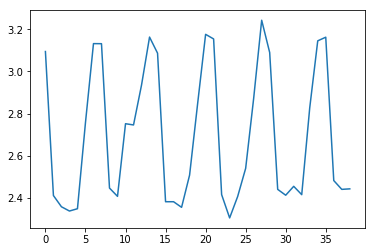

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.057711   
air_0164b9927d20bcc3_2017-04-23              1.414516   
air_0241aa3964b7f861_2017-04-23              2.225333   
air_0328696196e46f18_2017-04-23              2.221709   
air_034a3d5b40d5b1b1_2017-04-23              3.510274   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.828032  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.114496  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.256564  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.223082  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.457447

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')